In [1]:
import pandas as pd
import os
import pickle as pkl
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy.stats import spearmanr, weightedtau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [2]:
results_dirs = [
                # SelfTraining (just to test)
                "results/semisupervised_extrapolation_experiments_trainedwith_1_testedwith_2_avgfp_LogisticRegression_SelfTraining",
                
                # CoReg
                "results/semisupervised_extrapolation_experiments_trainedwith_1_testedwith_2_avgfp_MultiviewCoReg_multiviewcoregression",
                "results/semisupervised_extrapolation_experiments_trainedwith_1_2_3_4_5_6_7_8_9_10_testedwith_1_2_3_4_5_6_7_8_9_10_avgfp_MultiviewCoReg_MultiViewCoRegression",

                # ProteinBERT
                "results/proteinbert_extrapolation_experiments_trainedwith_1_testedwith_2_avgfp_proteinbert_regression_valfromtrain",
                "results/proteinbert_extrapolation_experiments_trainedwith_1_2_3_4_5_6_7_8_9_10_testedwith_1_2_3_4_5_6_7_8_9_10_avgfp_proteinbert_regression",

                # Supervised
                "results/supervised_extrapolation_experiments_trainedwith_1_testedwith_2_avgfp_Ridge",
                "results/supervised_extrapolation_experiments_trainedwith_1_2_3_4_5_6_7_8_9_10_testedwith_1_2_3_4_5_6_7_8_9_10_avgfp_Ridge",
                "results/supervised_extrapolation_experiments_trainedwith_1_testedwith_2_avgfp_KNeighborsRegressor",
                "results/supervised_extrapolation_experiments_trainedwith_1_2_3_4_5_6_7_8_9_10_testedwith_1_2_3_4_5_6_7_8_9_10_avgfp_KNeighborsRegressor",
                "results/supervised_extrapolation_experiments_trainedwith_1_testedwith_2_avgfp_SVR",
                "results/supervised_extrapolation_experiments_trainedwith_1_2_3_4_5_6_7_8_9_10_testedwith_1_2_3_4_5_6_7_8_9_10_avgfp_SVR",

                # Tritraining
                "results/semisupervised_extrapolation_experiments_trainedwith_1_testedwith_2_avgfp_Ridge_tritrainingregressor",
                "results/semisupervised_extrapolation_experiments_trainedwith_1_2_3_4_5_6_7_8_9_10_testedwith_1_2_3_4_5_6_7_8_9_10_avgfp_Ridge_tritrainingregressor",
                "results/semisupervised_extrapolation_experiments_trainedwith_1_2_testedwith_3_avgfp_SVR_tritrainingregressor",
                "results/semisupervised_extrapolation_experiments_trainedwith_1_2_3_4_5_6_7_8_9_10_testedwith_1_2_3_4_5_6_7_8_9_10_avgfp_SVR_tritrainingregressor"

                ]

In [3]:
# Pequeño arreglo para cambiar el nombre de los pred files dentro de la metadata
# Esto viene de que le he cambiado el nombre a la carpeta padre pero dentro de la metadata sigue el nombre antiguo
# results_df = pd.DataFrame(columns=["Encoding", "Labeled percentage", "Train size", "Train variants", "Test variants", "Model", "SS Method", "Normalization method", "Spearman's rho", "Weighted tau"])
# # For each results dir
# for results_dir in results_dirs:
#     # For each file in dir
#     for file in os.listdir(results_dir):
#         if "metadata" in file:
#             print(file)
#             metadata = pkl.load(open(os.path.join(results_dir, file), "rb"))
#             print(metadata["preds_file"])
#             if "valfromtest" in results_dir:
#                 metadata["preds_file"] = metadata["preds_file"].replace("results/proteinbert_extrapolation_experiments_trainedwith_1_testedwith_2_avgfp_proteinbert_regression/", "results/proteinbert_extrapolation_experiments_trainedwith_1_testedwith_2_avgfp_proteinbert_regression_valfromtest/")
#             elif "valfromtrain" in results_dir:
#                 metadata["preds_file"] = metadata["preds_file"].replace("results/proteinbert_extrapolation_experiments_trainedwith_1_testedwith_2_avgfp_proteinbert_regression/", "results/proteinbert_extrapolation_experiments_trainedwith_1_testedwith_2_avgfp_proteinbert_regression_valfromtrain/")

#             # Save new metadata
#             pkl.dump(metadata, open(os.path.join(results_dir, file), "wb"))
            

In [4]:
results_df = pd.DataFrame(columns=["Encoding", "Labeled percentage", "Train size", "Train variants", "Test variants", "Model", "SS Method", "Normalization method", "Spearman's rho", "Weighted tau"])
# For each results dir
for results_dir in results_dirs:
    # For each file in dir
    for file in os.listdir(results_dir):
        if "metadata" in file:
            print(file)
            metadata = pkl.load(open(os.path.join(results_dir, file), "rb"))
            if "semisupervised" in results_dir and not "SelfTraining" in results_dir:
                if metadata["Encoding2"] == None:
                    enc = metadata["Encoding1"]
                else:
                    enc = metadata["Encoding1"] + " + " + metadata["Encoding2"]
            else:
                enc = metadata["Encoding"]
            labeled_percentage = metadata["Labeled percentage"]
            model = metadata["Model"]
            ss_method = metadata["SS Method"]
            normalization_method = metadata["normalization_method"]
            n_splits = metadata["n_splits"]
            preds_file = metadata["preds_file"]
            pred_mode = metadata["pred_mode"]
            train_variants = "_".join([str(v) for v in metadata["Train variants"]])
            test_variants = "_".join([str(v) for v in metadata["Test variants"]])

            # Load the results
            results = pkl.load(open(preds_file, "rb"))

            # Quick step to test validation set influence
            if model == "ProteinBERT":
                if "valfromtest" in results_dir:
                    model = "ProteinBERT (val from test)"
                elif "valfromtrain" in results_dir:
                    model = "ProteinBERT (val from train)"
            
            # For each split
            for split in range(n_splits):
                # Get the results
                results_split = results[split]
                y_proba = results_split["y_proba"]
                original_y_test = results_split["original_y_test"]
                y_test = results_split["y_test"]
              
                train_size = results_split["train_len"]

                mse = mean_squared_error(original_y_test, y_proba)
                spearman_r = spearmanr(original_y_test, y_proba)[0]
                weighted_tau = weightedtau(original_y_test, y_proba)[0]

                # Add the results to the dataframe
                results_df = pd.concat([results_df, 
                                        pd.DataFrame({"Encoding": enc,
                                                      "Labeled percentage": labeled_percentage,
                                                      "Train size": train_size,
                                                      "Train variants": train_variants,
                                                      "Test variants": test_variants,
                                                      "Model": model,
                                                      "Prediction mode": pred_mode,
                                                      "SS Method": ss_method,
                                                      "Normalization method": normalization_method,
                                                      "MSE": mse,
                                                      "Spearman's rho": spearman_r,
                                                      "Weighted tau": weighted_tau
                                                      }, index=[0])], ignore_index=True)
            

pred_dict_ss_One_hot_1_metadata.pkl
pred_dict_ss_One_hot_0.01_metadata.pkl
pred_dict_ss_One_hot_0.05_metadata.pkl
pred_dict_ss_One_hot_0.1_metadata.pkl
pred_dict_ss_One_hot_0.75_metadata.pkl
pred_dict_ss_One_hot_0.25_metadata.pkl
pred_dict_ss_One_hot_0.5_metadata.pkl
pred_dict_ss_One_hot_0.01_metadata.pkl
pred_dict_ss_One_hot_0.05_metadata.pkl
pred_dict_ss_One_hot_0.1_metadata.pkl
pred_dict_ss_One_hot_0.25_metadata.pkl
pred_dict_ss_One_hot_0.75_metadata.pkl
pred_dict_ss_One_hot_0.5_metadata.pkl
pred_dict_ss_One_hot_0.001_metadata.pkl
pred_dict_ss_One_hot_0.0025_metadata.pkl
pred_dict_ss_One_hot_0.005_metadata.pkl
pred_dict_ss_One_hot_0.01_metadata.pkl
pred_dict_ss_One_hot_0.05_metadata.pkl
pred_dict_ss_One_hot_0.1_metadata.pkl
pred_dict_ss_One_hot_0.25_metadata.pkl
pred_dict_ss_One_hot_0.75_metadata.pkl
pred_dict_proteinbert_1_metadata.pkl
pred_dict_proteinbert_0.75_metadata.pkl
pred_dict_proteinbert_0.5_metadata.pkl
pred_dict_proteinbert_0.25_metadata.pkl
pred_dict_proteinbert_0.1_met

In [5]:
# Manually set the semi-supervised methods for 100% labeled data to their base models results (SS is not applied when 100% labeled data anyway)
ss_models = ["TriTrainingRegressor", "MultiviewCoReg", "SelfTraining"]

for ss_model in ss_models:
    for base_model in results_df[results_df["SS Method"] == ss_model]["Model"].unique():
        # Duplicate all the rows where column Model is base_model and SS Method in None but changing the SS Method to ss_model
        new_rows = results_df[(results_df["Model"] == base_model) & (results_df["SS Method"] == "None")].copy()
        new_rows["SS Method"] = ss_model
        results_df = pd.concat([results_df, new_rows], ignore_index=True)

In [6]:
results_df[(results_df["Model"] == "KNeighborsRegressor") & (results_df["Labeled percentage"] == 1) & (results_df["Train variants"] == "1_2_3_4_5_6_7_8_9_10") & (results_df["Test variants"] == "1_2_3_4_5_6_7_8_9_10") & (results_df["Encoding"] == "One_hot")]

,Encoding,Labeled percentage,Train size,Train variants,Test variants,Model,SS Method,Normalization method,Spearman's rho,Weighted tau,Prediction mode,MSE
340,One_hot,1,26052,1_2_3_4_5_6_7_8_9_10,1_2_3_4_5_6_7_8_9_10,KNeighborsRegressor,None,None,0.590951,0.555148,regression,1.269222
341,One_hot,1,26052,1_2_3_4_5_6_7_8_9_10,1_2_3_4_5_6_7_8_9_10,KNeighborsRegressor,None,None,0.590951,0.555148,regression,1.269222
342,One_hot,1,26052,1_2_3_4_5_6_7_8_9_10,1_2_3_4_5_6_7_8_9_10,KNeighborsRegressor,None,None,0.590951,0.555148,regression,1.269222
343,One_hot,1,26052,1_2_3_4_5_6_7_8_9_10,1_2_3_4_5_6_7_8_9_10,KNeighborsRegressor,None,None,0.590951,0.555148,regression,1.269222
344,One_hot,1,26052,1_2_3_4_5_6_7_8_9_10,1_2_3_4_5_6_7_8_9_10,KNeighborsRegressor,None,None,0.590951,0.555148,regression,1.269222


In [7]:
results_df[(results_df["Labeled percentage"] == 0.0025) & (results_df["Train variants"] == "1_2_3_4_5_6_7_8_9_10")]

,Encoding,Labeled percentage,Train size,Train variants,Test variants,Model,SS Method,Normalization method,Spearman's rho,Weighted tau,Prediction mode,MSE
70,One_hot,0.0025,65,1_2_3_4_5_6_7_8_9_10,1_2_3_4_5_6_7_8_9_10,MultiviewCoReg,MultiviewCoReg,None,0.182387,0.291496,regression,1.995242
71,One_hot,0.0025,65,1_2_3_4_5_6_7_8_9_10,1_2_3_4_5_6_7_8_9_10,MultiviewCoReg,MultiviewCoReg,None,0.143727,0.229648,regression,1.871236
72,One_hot,0.0025,65,1_2_3_4_5_6_7_8_9_10,1_2_3_4_5_6_7_8_9_10,MultiviewCoReg,MultiviewCoReg,None,0.144457,0.156632,regression,1.675993
73,One_hot,0.0025,65,1_2_3_4_5_6_7_8_9_10,1_2_3_4_5_6_7_8_9_10,MultiviewCoReg,MultiviewCoReg,None,0.125939,0.202521,regression,1.359686
74,One_hot,0.0025,65,1_2_3_4_5_6_7_8_9_10,1_2_3_4_5_6_7_8_9_10,MultiviewCoReg,MultiviewCoReg,None,0.081764,0.045912,regression,1.902855
180,None,0.0025,52,1_2_3_4_5_6_7_8_9_10,1_2_3_4_5_6_7_8_9_10,ProteinBERT,None,None,0.433053,0.298980,regression,0.887170
181,None,0.0025,52,1_2_3_4_5_6_7_8_9_10,1_2_3_4_5_6_7_8_9_10,ProteinBERT,None,None,0.511099,0.305346,regression,0.788772
182,None,0.0025,52,1_2_3_4_5_6_7_8_9_10,1_2_3_4_5_6_7_8_9_10,ProteinBERT,None,None,0.554294,0.408820,regression,0.745507
183,None,0.0025,52,1_2_3_4_5_6_7_8_9_10,1_2_3_4_5_6_7_8_9_10,ProteinBERT,None,None,0.467881,0.332046,regression,0.898571
184,None,0.0025,52,1_2_3_4_5_6_7_8_9_10,1_2_3_4_5_6_7_8_9_10,ProteinBERT,None,None,0.409009,0.266396,regression,0.966440


In [8]:
# metric = "Spearman's rho"   # "MSE", "Spearman's rho" or "Weighted tau"
metric = "Weighted tau"
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
# Rank df by AUC mean grouped by view and labeled

labeled_percentage = 0.05

# train_variants = "1"
# test_variants = "2"
train_variants = "1_2_3_4_5_6_7_8_9_10"
test_variants = "1_2_3_4_5_6_7_8_9_10"

display_df = results_df[(results_df["Labeled percentage"] == labeled_percentage) & (results_df["Train variants"] == train_variants) & (results_df["Test variants"] == test_variants)]
display(display_df.groupby(['Model', 'SS Method', 'Labeled percentage', 'Train size', 'Prediction mode', 'Train variants', 'Test variants']).mean().sort_values(by=metric, ascending=False))

Spearman's rho  \
Model               SS Method            Labeled percentage Train size Prediction mode Train variants       Test variants                          
ProteinBERT         None                 0.05               1042       regression      1_2_3_4_5_6_7_8_9_10 1_2_3_4_5_6_7_8_9_10        0.809450   
SVR                 None                 0.05               1302       regression      1_2_3_4_5_6_7_8_9_10 1_2_3_4_5_6_7_8_9_10        0.762531   
                    TriTrainingRegressor 0.05               1302       regression      1_2_3_4_5_6_7_8_9_10 1_2_3_4_5_6_7_8_9_10        0.748155   
Ridge               TriTrainingRegressor 0.05               1302       regression      1_2_3_4_5_6_7_8_9_10 1_2_3_4_5_6_7_8_9_10        0.762080   
                    None                 0.05               1302       regression      1_2_3_4_5_6_7_8_9_10 1_2_3_4_5_6_7_8_9_10        0.763181   
MultiviewCoReg      MultiviewCoReg       0.05               1302       regression      1_2_3_4_5_6_7_8_9_10 1_2_3_4_5_6_7_8_9_10        0.379354   
KNeighborsRegressor None                 0.05               1302       regression      1_2_3_4_5_6_7_8_9_10 1_2_3_4_5_6_7_8_9_10        0.347893   

                                                                                                                                  Weighted tau  \
Model               SS Method            Labeled percentage Train size Prediction mode Train variants       Test variants                        
ProteinBERT         None                 0.05               1042       regression      1_2_3_4_5_6_7_8_9_10 1_2_3_4_5_6_7_8_9_10      0.703406   
SVR                 None                 0.05               1302       regression      1_2_3_4_5_6_7_8_9_10 1_2_3_4_5_6_7_8_9_10      0.639986   
                    TriTrainingRegressor 0.05               1302       regression      1_2_3_4_5_6_7_8_9_10 1_2_3_4_5_6_7_8_9_10      0.628143   
Ridge               TriTrainingRegressor 0.05               1302       regression      1_2_3_4_5_6_7_8_9_10 1_2_3_4_5_6_7_8_9_10      0.596257   
                    None                 0.05               1302       regression      1_2_3_4_5_6_7_8_9_10 1_2_3_4_5_6_7_8_9_10      0.593560   
MultiviewCoReg      MultiviewCoReg       0.05               1302       regression      1_2_3_4_5_6_7_8_9_10 1_2_3_4_5_6_7_8_9_10      0.362956   
KNeighborsRegressor None                 0.05               1302       regression      1_2_3_4_5_6_7_8_9_10 1_2_3_4_5_6_7_8_9_10      0.339740   

                                                                                                                                       MSE  
Model               SS Method            Labeled percentage Train size Prediction mode Train variants       Test variants                   
ProteinBERT         None                 0.05               1042       regression      1_2_3_4_5_6_7_8_9_10 1_2_3_4_5_6_7_8_9_10  0.266397  
SVR                 None                 0.05               1302       regression      1_2_3_4_5_6_7_8_9_10 1_2_3_4_5_6_7_8_9_10  0.923394  
                    TriTrainingRegressor 0.05               1302       regression      1_2_3_4_5_6_7_8_9_10 1_2_3_4_5_6_7_8_9_10  0.927588  
Ridge               TriTrainingRegressor 0.05               1302       regression      1_2_3_4_5_6_7_8_9_10 1_2_3_4_5_6_7_8_9_10  0.513410  
                    None                 0.05               1302       regression      1_2_3_4_5_6_7_8_9_10 1_2_3_4_5_6_7_8_9_10  0.514621  
MultiviewCoReg      MultiviewCoReg       0.05               1302       regression      1_2_3_4_5_6_7_8_9_10 1_2_3_4_5_6_7_8_9_10  1.463986  
KNeighborsRegressor None                 0.05               1302       regression      1_2_3_4_5_6_7_8_9_10 1_2_3_4_5_6_7_8_9_10  1.448172

In [9]:
selected_metric = "Weighted tau"

/tmp/ipykernel_64312/847487931.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df["Method"] = boxplot_df["Model"] + " | " + boxplot_df["SS Method"]


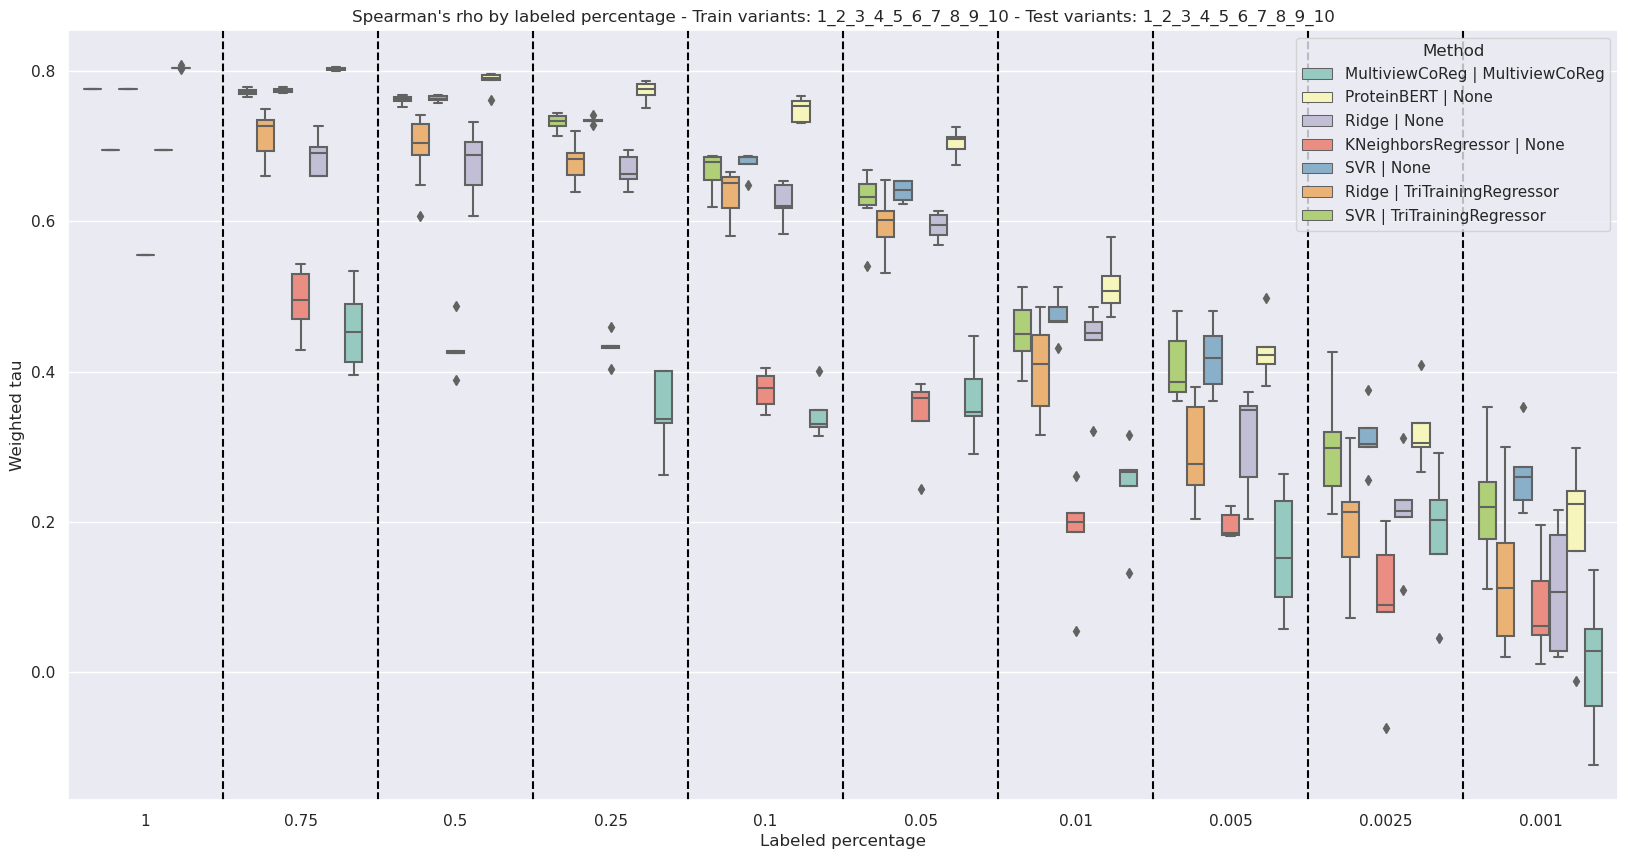

In [10]:
plt.figure(figsize=(20, 10))

# Boxplot dataframe from results_df grouped by Model and SS Method
boxplot_df = results_df[(results_df["Train variants"] == train_variants) & (results_df["Test variants"] == test_variants)]
boxplot_df["Method"] = boxplot_df["Model"] + " | " + boxplot_df["SS Method"]

# Boxplot grouped by labeled percentage
sns.set_theme(style="darkgrid")
ax = sns.boxplot(x="Labeled percentage", y=selected_metric, data=boxplot_df, hue="Method", palette="Set3")
ax.set_title("Spearman's rho by labeled percentage - Train variants: " + train_variants + " - Test variants: " + test_variants)
#ax.set_ylim(0, 1)

[plt.axvline(x+0.5, color = 'black', linestyle='--') for x in range(len(boxplot_df["Labeled percentage"].unique())-1)]

# Flip x axis
ax.invert_xaxis()

plt.show()